# Engraftment of AMR genes

1. What AMR genes crop up in placebo and FMT patients?
2. What types of genes come up?


In [1]:
import pathlib, itertools
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div, scipy.stats as stats, skbio.stats.ordination as ordination
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

In [2]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

#make a dictionary of colors for sources
dd_source_set = {'shared': (0.878, 0.878, 0.878),
                 'patient': (0.909, 0.470, 0.470),
                 'env': (0.933, 0.674, 0.349),
                 'donor0044': (0.305, 0.749, 0.776),
                 'donor0073': (0.643, 0.450, 0.850),
                 'donor0044_0073': (0.376, 0.470, 0.803),
                 'donor': (0.376, 0.470, 0.803)}

dd_source_set_tint = {k: tuple([x + ((255 - 255*x) * 0.8)/255 for x in v]) for k, v in dd_source_set.items()}

In [3]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [4]:
#make a dictionary of patient to publication label
pub_label_dict = md_pat.set_index('patient').to_dict()['label_pub']

In [5]:
#read in annotations
db = '/Users/ndchu/Documents/uc_fmt/metagenomics/function/amr/cheng_amr_10.1.2018_update'
ncbi_amr = pd.read_csv(db + '/ncbi_amr_db_mapping_nucleotide.csv')
card_amr = pd.read_csv(db + '/card_amr_class_annotation.csv')

In [6]:
#read in the file
amr_sb = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/amr/sb_AG102018/amr_sb_all.tsv.gz',
                     sep='\t', compression='gzip')

In [7]:
#add metadata
amr_sb = amr_sb.merge(md, left_on='sample', right_on='sample_id')

#add antibiotic information
amr_class = pd.concat([ncbi_amr[['genbank_prot_accession', 
                                 'antibiotic_class']].rename(columns={'genbank_prot_accession': 'prot_accession'}),
                       card_amr[['Protein Accession', 
                                 'antibiotic_class']].rename(columns={'Protein Accession': 'prot_accession'}),
                       ncbi_amr[['refseq_prot_accession', 
                                 'antibiotic_class']].rename(columns={'refseq_prot_accession': 'prot_accession'})])

#get rid of strain
amr_class.loc[:, 'prot_accession_nostr'] = amr_class['prot_accession'].str.split('.').str[0]
tmp_dict = amr_class.set_index('prot_accession_nostr').to_dict()['antibiotic_class']

#add abx information
amr_sb.loc[:, 'prot_accession'] = amr_sb['Family'].str.split('|').str[1]
tmp = []
for x in amr_sb['prot_accession']:
    test = x.rsplit('_', 1)[0]
    if len(test) > 2:
        tmp.append(test)
    else:
        tmp.append(x)
amr_sb.loc[:, 'antibiotic_class'] = [tmp_dict[x] for x in tmp]

In [8]:
#add antibiotics class data
amr_sb.loc[:, 'accession'] = amr_sb['Family'].str.split('|').str[1]

ncbi_amr.loc[:, 'accession'] = ncbi_amr['refseq_prot_accession'].str.replace('.', '_', regex=False)
card_amr.loc[:, 'accession'] = card_amr['Protein Accession'].str.replace('.', '_', regex=False)
acc_cls_map = pd.concat([ncbi_amr[['accession', 'antibiotic_class']], 
                         card_amr[['accession', 'antibiotic_class']]])

amr_sb = amr_sb.merge(acc_cls_map)

In [9]:
#get abundance of each antibiotic class in each sample
amr_cls = amr_sb[['sample', 'Count', 'antibiotic_class']].groupby(['sample', 'antibiotic_class']).sum()
amr_cls = amr_cls.reset_index()
amr_cls = amr_cls.merge(md, left_on='sample', right_on='sample_id')

## What antibiotic clusters engraft

In [10]:
donor_amr_dict = {'0044': set(amr_sb.loc[amr_sb['patient'] == '0044']['Family']),
                  '0073': set(amr_sb.loc[amr_sb['patient'] == '0073']['Family'])}

In [88]:
amr_eng = []
for patient, sub_df in amr_sb.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    #get patient baseline amr genes
    bl_sam = md.loc[(md['patient'] == patient) & \
                    (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_amr = set(sub_df.loc[sub_df['sample_id'].isin(bl_sam)]['Family'])
    
    #get patient pfmt amr genes that occur at least 3 times
    pfmt_sam = md.loc[(md['patient'] == patient) & \
                      (md['days_past_fmt'] > 0)]['sample_id'].tolist()
    tmp = sub_df.loc[sub_df['sample_id'].isin(pfmt_sam)]
    tmp = tmp.groupby('Family').size()
    pfmt_amr = set(tmp.loc[tmp >= 3].index)
    
    if sub_df['treatment'].iloc[0] == 'placebo':
        eng_amr = pfmt_amr - bl_amr
        #add env amr
        amr_eng.extend([[patient, x, 'env'] for x in eng_amr])
        #add patient amr
        pat_amr = pfmt_amr & bl_amr
        amr_eng.extend([[patient, x, 'patient'] for x in pat_amr])
    else:
        donor = sub_df['fmt_induction'].iloc[0]
        donor_amr = donor_amr_dict[donor]
        #get engrafted donor amr
        eng_amr = (donor_amr & pfmt_amr) - bl_amr
        amr_eng.extend([[patient, x, 'donor'] for x in eng_amr])
        #get shared amr
        shared_amr = donor_amr & pfmt_amr & bl_amr
        amr_eng.extend([[patient, x, 'shared'] for x in shared_amr])
        #get all the unknowns
        env_amr = pfmt_amr - donor_amr - bl_amr
        amr_eng.extend([[patient, x, 'env'] for x in env_amr])
        #get patient amr
        pat_amr = (pfmt_amr - donor_amr) & bl_amr
        amr_eng.extend([[patient, x, 'patient'] for x in pat_amr])

amr_eng_df = pd.DataFrame(amr_eng, columns=['patient', 'amr_family', 'source'])

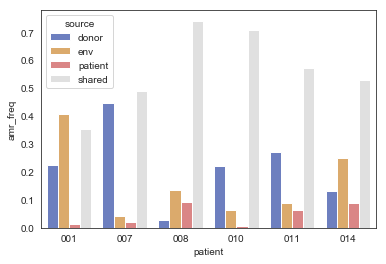

In [92]:
# plot the frequencies of these sources overall for each patient
amr_eng_cts_pp = amr_eng_df.groupby(['patient', 'source']).size()
amr_eng_freq = amr_eng_cts_pp / amr_eng_df.groupby('patient').size()
amr_eng_freq = amr_eng_freq.rename('amr_freq').reset_index()

# plot for the FMT patients
fmt_pats = set(md.loc[md['treatment'] == 'fmt']['patient'].unique())
plt_df = amr_eng_freq.loc[amr_eng_freq['patient'].isin(fmt_pats)]
sns.barplot(x='patient', y='amr_freq',
            hue='source',
            data=plt_df,
            palette=dd_source_set)

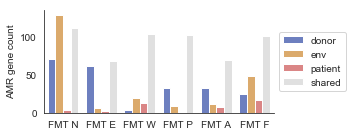

In [104]:
# plot raw numbers as well
amr_eng_cts_pp = amr_eng_cts_pp.rename('amr_ct')
tmp = amr_eng_cts_pp.reset_index()

plt_df = tmp.loc[tmp['patient'].isin(fmt_pats)]
plt_df.loc[:, 'patient_plt'] = plt_df['patient'].apply(lambda x: pub_label_dict[x])

fig = plt.figure(figsize = (5,2))

ax = sns.barplot(x='patient_plt', y='amr_ct',
                 hue='source', data=plt_df,
                 palette=dd_source_set)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel('AMR gene count')
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

## Longitudinal engraftment

In [171]:
amr_source = []
for patient, sub_df in amr_sb.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    #get patient baseline amr genes
    bl_sam = md.loc[(md['patient'] == patient) & \
                    (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_amr = set(sub_df.loc[sub_df['sample_id'].isin(bl_sam)]['Family'])
    
    for sample, sub_sub_df in sub_df.groupby('sample_id'):
        sam_amr = set(sub_sub_df['Family'])
        
        if sub_df['treatment'].iloc[0] == 'placebo':
            pat_amr = sam_amr & bl_amr #patient amr
            env_amr = sam_amr - bl_amr #env amr
            
            amr_source.extend([[patient, sample, 
                                x, 'patient'] for x in pat_amr])
            amr_source.extend([[patient, sample, 
                                x, 'env'] for x in env_amr])
        
        elif sub_df['treatment'].iloc[0] == 'fmt':
            donor = sub_df['fmt_induction'].iloc[0]
            donor_amr = donor_amr_dict[donor]
            
            pat_amr = (sam_amr & bl_amr) - donor_amr #patient amr
            don_amr = (donor_amr & sam_amr) - bl_amr #donor amr
            shr_amr = donor_amr & sam_amr & bl_amr #shared amr
            env_amr = sam_amr - donor_amr - bl_amr #env amr
            
            amr_source.extend([[patient, sample, 
                                x, 'patient'] for x in pat_amr])
            amr_source.extend([[patient, sample, 
                                x, 'env'] for x in env_amr])
            amr_source.extend([[patient, sample, 
                                x, 'donor'] for x in don_amr])
            amr_source.extend([[patient, sample, 
                                x, 'shared'] for x in shr_amr])

amr_source_df = pd.DataFrame(amr_source, 
                             columns=['patient', 'sample_id', 
                                      'Family', 'source'])

In [172]:
# add metadata
amr_source_df = amr_source_df.merge(amr_sb)

In [173]:
# write to a file
amr_source_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/amr/sb_AG102018/amr_source_2019-04-16.tsv.gz',
                     sep='\t', index=False, compression='gzip')

In [5]:
# read in a file
amr_source_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/amr/sb_AG102018/amr_source_2019-04-16.tsv.gz',
                           sep='\t', compression='gzip', dtype={'patient': 'object'})

In [6]:
# get frequencies over time
amr_source_freq = amr_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt', 'source']).size()
amr_sample_sum = amr_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt']).size()

amr_source_freq = amr_source_freq.rename('source_count').reset_index()
amr_sample_sum = amr_sample_sum.rename('amr_count').reset_index()

amr_source_freq = amr_source_freq.merge(amr_sample_sum)
amr_source_freq.loc[:, 'source_freq'] = amr_source_freq['source_count'] / amr_source_freq['amr_count']

In [9]:
#get rid of samples with less than 2 butyrate genes, since they are likely errors
amr_source_freq = amr_source_freq.loc[amr_source_freq['amr_count'] > 1]

#fill the zeroes
amr_source_freq_ftab = amr_source_freq.pivot(index='sample_id',
                                               columns='source',
                                               values='source_freq')
amr_source_freq_filled = pd.melt(amr_source_freq_ftab.reset_index(),
                                  id_vars='sample_id',
                                  var_name='source',
                                  value_name='source_freq')
#add metadata
amr_source_freq_filled = amr_source_freq_filled.fillna(0)
tmp = amr_source_freq[['sample_id', 'source', 'source_count']]
amr_source_freq_filled = amr_source_freq_filled.merge(tmp, how='outer').fillna(0)
tmp = amr_source_freq[['sample_id', 'amr_count']].drop_duplicates()
amr_source_freq_filled = amr_source_freq_filled.merge(tmp)
amr_source_freq_filled = amr_source_freq_filled.merge(md)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


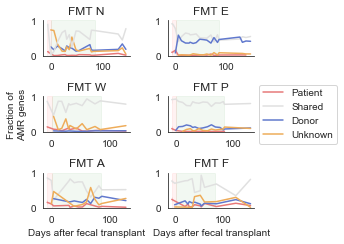

In [13]:
# plot these amr sources
#collapse all donor categories

fig = plt.figure(figsize = (5,3.5))

counter = 1
for patient, sub_df in amr_source_freq.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [3]:
            ax.set_ylabel('Fraction of\nAMR genes')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Patient', 'Shared',
                             'Donor', 'Unknown']
                     )
    
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engfmt_ts_2019-05-04.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engfmt_ts_2019-05-04.pdf',
            dpi=300)

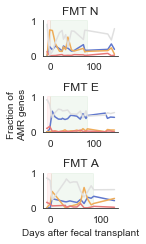

In [10]:
# plot FMT N, E, and A

fig = plt.figure(figsize = (2,3.5))

counter = 1
for patient, sub_df in amr_source_freq_filled.groupby('patient'):
    if patient in ['001', '007', '011']:
        ax = fig.add_subplot(3,1,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [2]:
            ax.set_ylabel('Fraction of\nAMR genes')
        else:
            ax.set_ylabel('')
        
        if counter in [3]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        ax.legend_.remove()
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engfmt_ts_NEA_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engfmt_ts_NEA_2019-05-07.pdf',
            dpi=300)

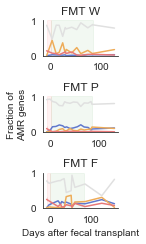

In [11]:
# plot FMT WPF

fig = plt.figure(figsize = (2,3.5))

counter = 1
for patient, sub_df in amr_source_freq_filled.groupby('patient'):
    if patient in ['008', '010', '014']:
        ax = fig.add_subplot(3,1,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [2]:
            ax.set_ylabel('Fraction of\nAMR genes')
        else:
            ax.set_ylabel('')
        
        if counter in [3]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        ax.legend_.remove()
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engfmt_ts_WPF_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engfmt_ts_WPF_2019-05-07.pdf',
            dpi=300)

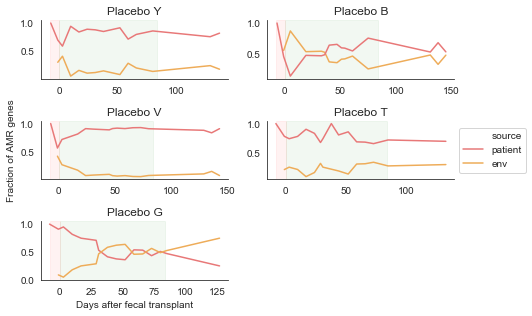

In [178]:
#plot these for placebo patients as well

fig = plt.figure(figsize = (7.5,4.5))

counter = 1
for patient, sub_df in amr_source_freq.groupby('patient'):
    if patient in ['004', '005', '006', '009', '013']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        #ax.set_ylim(0, 0.9)
        
        if counter in [3]:
            ax.set_ylabel('Fraction of AMR genes')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     #labels=['Patient', 'Shared',
                     #        'Donor', 'Unknown']
                     )
    
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engplc_ts_2019-04-17.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engplc_ts_2019-04-17.pdf',
            dpi=300)

### Plot cumulative abundance

In [12]:
#do this for cumulative abundance
amr_source_cabun = amr_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt', 'source'])['Count'].sum()

amr_source_cabun = amr_source_cabun.rename('cum_abun').reset_index()

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


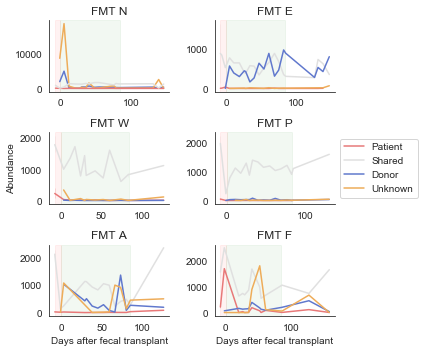

In [13]:
# plot these vf sources
#collapse all donor categories

fig = plt.figure(figsize = (6,5))

counter = 1
for patient, sub_df in amr_source_cabun.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='cum_abun',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        #ax.set_ylim(0, 1)
        
        if counter in [3]:
            ax.set_ylabel('Abundance')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Patient', 'Shared',
                             'Donor', 'Unknown']
                     )
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_cabun_source_ts_2019-05-06.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_cabun_source_ts_2019-05-06.pdf',
            dpi=300)